# Assignment - Logistic Regression

## Import libraries

In [469]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
import re
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt

## Download data

In [470]:
nltk.download("twitter_samples")
nltk.download("stopwords")

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/mikael/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Retrieve Data

In [471]:
all_positive_tweets = twitter_samples.strings("positive_tweets.json")
all_negative_tweets = twitter_samples.strings("negative_tweets.json")

## Make train / test split

In [472]:
TRAIN_PERC = 0.8
TEST_PERC = 0.2

assert len(all_positive_tweets) == len(all_negative_tweets)

print("Len all positive tweets: ", len(all_positive_tweets))
print("Len all negative tweets: ", len(all_negative_tweets))

TRAIN_NR = int(round(TRAIN_PERC * len(all_positive_tweets), 0))
TEST_NR = int(round(TEST_PERC * len(all_positive_tweets), 0))

X_train_pos = all_positive_tweets[:TRAIN_NR]
X_train_neg = all_negative_tweets[:TRAIN_NR]
X_test_pos = all_positive_tweets[TRAIN_NR:]
X_test_neg = all_negative_tweets[TRAIN_NR:]

X_train = X_train_pos + X_train_neg
X_test = X_test_pos + X_test_neg

Y_train = np.append(np.ones(len(X_train_pos)), np.zeros(len(X_train_neg)))
Y_test = np.append(np.ones(len(X_test_pos)), np.zeros(len(X_test_neg)))

Len all positive tweets:  5000
Len all negative tweets:  5000


## Process tweets

1. Remove handles and urls
2. Remove stopwords and punctuation
3. Stemming
4. Lowercasing


In [473]:
stemmer = PorterStemmer()
tokensizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)


def process_tweet(tweet):
    # 1. Remove handles, tickers, re-tweet sign, hyperlinks, hashtags
    # ---------------------------------------------------------------

    # 1.1. Remove stock market tickers like $GE
    tweet = re.sub(r"\$\w*", "", tweet)

    # 1.2. Remove old style retweet text "RT"
    tweet = re.sub(r"^RT[\s]+", "", tweet)

    # 1.3. Remove hyperlinks
    tweet = re.sub(r"https?://[^\s\n\r]+", "", tweet)

    # 1.4. remove hashtag
    tweet = re.sub(r"#", "", tweet)

    # 2. Tokenize the tweet
    # ------------------------------------------------

    tweet_tokens = tokensizer.tokenize(tweet)

    # 3. Remove stopwords, punctuation. Perform stemming and transform to lowercase
    # -----------------------------------------------------------------------------

    stop_words = list(set(stopwords.words("english")))

    processed_tweet = [
        stemmer.stem(word).lower()
        for word in tweet_tokens
        if word not in stop_words and word not in string.punctuation
    ]

    return processed_tweet

## Test `process_tweet()`

In [474]:
print(process_tweet(X_train[0]))
print(process_tweet(X_train[1]))
print(process_tweet(X_train[2]))
print(process_tweet(X_train[3]))

['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']
['hey', 'jame', 'odd', ':/', 'pleas', 'call', 'contact', 'centr', '02392441234', 'abl', 'assist', ':)', 'mani', 'thank']
['listen', 'last', 'night', ':)', 'bleed', 'amaz', 'track', 'scotland']
['congrat', ':)']


## Build frequency dictionary

In [475]:
def build_freqs(tweets, ys):
    freq_dict = {}

    for tweet, y in zip(tweets, ys):
        for word in process_tweet(tweet):
            if (word, y) not in freq_dict:
                freq_dict[(word, y)] = 1
            else:
                freq_dict[(word, y)] += 1

    return freq_dict

In [476]:
freq_dict = build_freqs(X_train, Y_train)

## Test the frequency dictionary

In [477]:
for k, v in list(freq_dict.items())[:10]:
    print(f"key: {k} - value: {v}")

key: ('followfriday', 1.0) - value: 23
key: ('top', 1.0) - value: 30
key: ('engag', 1.0) - value: 7
key: ('member', 1.0) - value: 14
key: ('commun', 1.0) - value: 27
key: ('week', 1.0) - value: 72
key: (':)', 1.0) - value: 2960
key: ('hey', 1.0) - value: 60
key: ('jame', 1.0) - value: 7
key: ('odd', 1.0) - value: 2


## Train the model

### Sigmoid function (to predict ^y or h)

In [478]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Set start values of theta

In [479]:
theta = np.array([0.0, 0.0, 0.0])
alpha = 1e-8
m = len(X_train)

### Build features matrix

In [480]:
def extract_features(x, y, freq_dict, process_tweet=process_tweet):
    X = []
    for tweet, label in zip(x, y):
        pos_freq = 0
        neg_freq = 0
        tweet_tokens = process_tweet(tweet)
        for token in tweet_tokens:
            pos_freq += freq_dict[(token, 1)] if (token, 1) in freq_dict else 0
            neg_freq += freq_dict[(token, 0)] if (token, 0) in freq_dict else 0
        X.append([1, pos_freq, neg_freq])

    X = np.array(X)
    return X

### Gradient descent

In [481]:
def gradient_descent(x, y, theta, freq_dict, process_tweet, alpha, epochs):

    to_plot = []
    xf = extract_features(x, y, freq_dict, process_tweet)

    for epoch in range(1, epochs):

        # Dimension Analysis:
        # ---------------------
        #
        # z -> theta [1, 3] x xf [m, 3]
        # z -> [m, 1]
        # z = theta [1, 3] x xf.T [3, m] - > [1, m]
        # z = z.T -> [m, 1]
        z = np.matmul(theta, xf.T)
        h = sigmoid(z)
        h = np.clip(h, 1e-10, 1 - 1e-10)
        # Dimension analysis
        # -------------------
        # xf -> [m, 3]
        # h -> [m, 1]
        # y -> [m, 1]
        # grad = xf.T [3, m] x (h-y) [m, 1] -> [3, 1]
        # theta -> [1, 3]
        # grad -> [1, 3]
        # grad = grad.T
        grad = (1 / m) * np.matmul(xf.T, h - y)
        grad = grad.T
        assert grad.shape == theta.shape
        J = -(1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        to_plot.append([J, epoch])
        theta = theta - alpha * grad
    return J, theta, np.array(to_plot)

In [482]:
J, theta, to_plot = gradient_descent(
    x=X_train,
    y=Y_train,
    theta=theta,
    freq_dict=freq_dict,
    process_tweet=process_tweet,
    alpha=alpha,
    epochs=60000,
)

In [483]:
epochs = to_plot[:, 1]
loss = to_plot[:, 0]

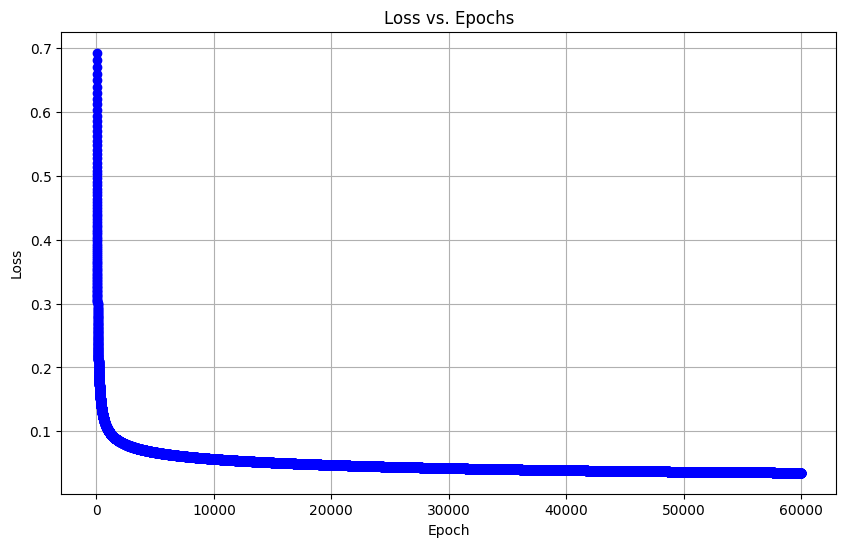

In [484]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epochs, loss, marker="o", linestyle="-", color="blue")
ax.set_title("Loss vs. Epochs")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(True)
plt.show()

## Test the logistic regression model

### Function for Model Prediction

In [485]:
def predict(x, theta):
    z = np.matmul(theta, x.T)
    h = sigmoid(z)
    h = np.clip(h, 1e-10, 1 - 1e-10)
    return h

### Extract the features of the tweets in X_test

In [486]:
features = extract_features(X_test, Y_test, freq_dict=freq_dict)

### Predict the y_hat / h / model outputs from X_test

In [487]:
h = predict(features, theta)

### Set values above 0.5 to 1 and below 0.5 to 0

In [488]:
h = np.where(h >= 0.5, 1, 0)

### Calculate the accuracy of the model

In [489]:
accuracy = np.sum(Y_test == h) / len(Y_test)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9945
